# Import Requirements

In [3]:

%load_ext autoreload

%autoreload 2

%matplotlib notebook

import os
import os.path as osp
import sys 
import time



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from data import *
from utils.augmentations import SSDAugmentation
from layers.modules import MultiBoxLoss
from architectures.ssd_feature_fused_deconv import build_ssd

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision as tv
import torch.optim as optim



In [6]:
import torch.utils.data as data
import torchvision.datasets

import numpy as np
from PIL import Image
import argparse

from matplotlib import pyplot as plt
import pandas as pd
import cv2 
import pickle as pkl
import random
import tarfile
import collections
import math
import datetime
import pickle


# Settings

In [7]:

from config_vgg16_ssd import *
import xml.etree.ElementTree as ET

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [9]:

def xavier(param):
    nn.init.xavier_uniform(param)


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)
        m.bias.data.zero_()


In [10]:
def plot(list_loss , fig, axes ):

    
    axes.clear()
    axes.set_title('plot loss')
    
    axes.plot(list_loss, label='training loss')
    axes.set_ylabel('Loss')
    axes.set_xlabel('iter') 
    axes.legend()
    
    
    plt.tight_layout()
    fig.canvas.draw()


In [11]:


def train(device, resume=None, num_iters=60000):
    
    #use voc config 
    
    cfg = voc
 
    ssd_net = build_ssd('train', cfg['min_dim'], cfg['num_classes'])
    dataset = VOCDetection(root=voc_root, 
                            transform=SSDAugmentation(cfg['min_dim'],
                             MEANS))
     
    
    if resume:
        print('Resuming training, loading previous training at ',resume)
        ssd_net.load_weights(resume ) 
        #strict is false if fine tuing from an existing ssd model 
        #ssd_weights = torch.load(resume ) 
        #ssd_net.load_state_dict(ssd_weights , strict = False )
        #ssd_net.feature_fusion.apply(weights_init) 
    else:
        vgg_weights = torch.load(basenet)
        print('Loading base network...')
        ssd_net.vgg.load_state_dict(vgg_weights)
        print('Initializing weights...')
        ssd_net.extras.apply(weights_init)
        ssd_net.loc.apply(weights_init)
        ssd_net.conf.apply(weights_init) 
        ssd_net.feature_fusion.apply(weights_init) 
        
    
    net = ssd_net
    
    #print(vgg_weight)
    #for param in net.vgg.parameters() :
    #    print(param.requires_grad)
    
    if device:
        net = torch.nn.DataParallel(ssd_net)
        torch.backends.cudnn.benchmark = True
        net = net.to(device)
        
    optimizer = optim.SGD(net.parameters(), lr, momentum, weight_decay)
    
    criterion = MultiBoxLoss(cfg['num_classes'], 0.5, True, 0, True, 3, 0.5,
                             False, torch.cuda.is_available())

    
    net.train()
    mode = 'train'
    
    
    loc_loss = 0
    conf_loss = 0
    epoch = 0
    print('Loading the dataset...')

    epoch_size = len(dataset) // batch_size
    print('Training SSD on: ',mode)

    step_index = 0

    #based on adapted code
    train_data_loader = data.DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=True,\
                               collate_fn=detection_collate,pin_memory=True)
    
    print("Images in the training set = " + str(len(dataset)))
    print("Images in a mini-batch = "+str(batch_size))
    print("mini-batches = " + str(len(train_data_loader)))
    
    
     # create batch iterator
    batch_iterator = iter(train_data_loader)
    print("STARTING - ITERATIONS")
    
    
    l_loss = []
    c_loss = []
    itr = []
    
    with open('trained_weights/vgg16_ssd_stats_SGD_feature_fusion.pkl','rb') as f:
        l_loss, c_loss, itr = pickle.load(f)   
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7, 6))
    
    
    start_itr = len(itr) 
    for iteration in range(start_itr , num_iters) : 
        if iteration != 0 and (iteration % epoch_size == 0):
            # reset epoch loss counters
            loc_loss = 0
            conf_loss = 0
            epoch += 1

        if iteration in cfg['lr_steps']:
            step_index += 1
            lr_dec = lr * (gamma ** (step_index))
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_dec
        
            
        ## load train data
        try:
            images, targets = next(batch_iterator)
        except StopIteration:
            batch_iterator = iter(train_data_loader)
            images, targets = next(batch_iterator)


        
        if device:
            images = images.cuda()
            targets = [ann.cuda() for ann in targets]
        else:
            images = images
            targets = [ann for ann in targets]
        
        # forward
        t0 = time.time()
        out = net(images)
    
        # backprop
        optimizer.zero_grad()
    
        loss_l, loss_c = criterion(out, targets)
        loss = loss_l + loss_c
    
        loss.backward()
    
        optimizer.step()
    
        l_loss.append(loss_l.data.item())
        c_loss.append(loss_c.data.item())
        
        t1 = time.time()
        loc_loss += loss_l.data.item()
        conf_loss += loss_c.data.item()
        
        itr.append(iteration)
        
        if iteration % 10 == 0:
            print('timer: %.4f sec.' % (t1 - t0))
            print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (loss.data.item()), end=' ')
            currentDT = datetime.datetime.now()
            print (currentDT.strftime("%H:%M:%S %p"))
            print("\n")
        
        
        if iteration != 0 and iteration % 10 == 0:
            print('Saving state, iter:', iteration)
            iter_name = math.ceil(iteration/100)*100
            if iteration % 100 == 0:
                torch.save(ssd_net.state_dict(), 'trained_weights/ssd_VGG16_VOC_feature_fusion' + '.pth') #dump on the same
            with open('trained_weights/vgg16_ssd_stats_SGD_feature_fusion.pkl','wb') as f:
                pkl.dump([l_loss, c_loss, itr], f)
            
          
            plot([l_loss[k]+c_loss[k] for k in range(len(l_loss))],fig,axes )
                

    torch.save(ssd_net.state_dict(),
               save_folder + data_set + '.pth') 

### 

In [12]:
!cat config_vgg16_ssd.py

#Initialize pointers
data_set = 'VOC'
dataset_root = '//datasets/home/12/312/vpotnuru/data/VOC0712/VOC2007/'
voc_root = '//datasets/home/12/312/vpotnuru/data/VOC0712/'
save_folder = 'trained_weights/'
eval_save_folder = 'eval/'
devkit_path = 'devkit_path/'
output_dir = "out/"

#Run related metaparameters

batch_size = 32
resume = None

#Optimization metaparameters
lr = 1e-3
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
    
confidence_threshold = 0.01
top_k = 5
cleanup = True

YEAR = '2012'
dataset_mean = (104, 117, 123)
set_type = 'train'

# models to start from , based on he problem 
trained_model = 'weights/ssd_pretrained.pth'
basenet = 'weights/vgg16_reducedfc.pth'


# Resume training 

Resuming training, loading previous training at  trained_weights/ssd_VGG16_VOC_feature_fusion.pth
Loading weights into state dict...
Finished!
Loading the dataset...
Training SSD on:  train
Images in the training set = 16551
Images in a mini-batch = 32
mini-batches = 518
STARTING - ITERATIONS


<IPython.core.display.Javascript object>


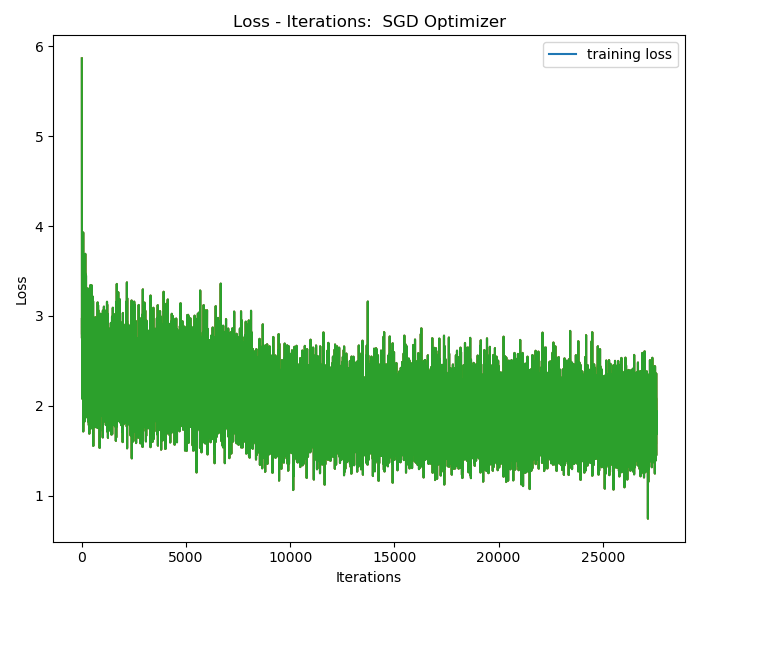

timer: 0.6181 sec.
iter 24590 || Loss: 2.1702 || 11:36:25 AM


Saving state, iter: 24590
timer: 0.7135 sec.
iter 24600 || Loss: 1.8893 || 11:36:34 AM


Saving state, iter: 24600
timer: 0.7748 sec.
iter 24610 || Loss: 1.7700 || 11:36:42 AM


Saving state, iter: 24610
timer: 0.6909 sec.
iter 24620 || Loss: 1.7749 || 11:36:49 AM


Saving state, iter: 24620
timer: 0.7174 sec.
iter 24630 || Loss: 2.4228 || 11:36:57 AM


Saving state, iter: 24630
timer: 0.5971 sec.
iter 24640 || Loss: 1.5905 || 11:37:05 AM


Saving state, iter: 24640
timer: 0.7432 sec.
iter 24650 || Loss: 1.9304 || 11:37:13 AM


Saving state, iter: 24650
timer: 0.7039 sec.
iter 24660 || Loss: 1.7398 || 11:37:20 AM


Saving state, iter: 24660
timer: 0.7221 sec.
iter 24670 || Loss: 1.5271 || 11:37:28 AM


Saving state, iter: 24670
timer: 0.6682 sec.
iter 24680 || Loss: 2.0757 || 11:37:36 AM


Saving state, iter: 24680
timer: 0.6936 sec.
iter 24690 || Loss: 2.0332 || 11:37:43 AM


Saving state, iter: 24690
timer: 0.6966 sec.
it

timer: 0.7113 sec.
iter 25520 || Loss: 1.3530 || 11:48:24 AM


Saving state, iter: 25520
timer: 0.7609 sec.
iter 25530 || Loss: 1.6698 || 11:48:32 AM


Saving state, iter: 25530
timer: 0.7237 sec.
iter 25540 || Loss: 1.4361 || 11:48:40 AM


Saving state, iter: 25540
timer: 0.6963 sec.
iter 25550 || Loss: 1.6767 || 11:48:48 AM


Saving state, iter: 25550
timer: 0.7802 sec.
iter 25560 || Loss: 1.8479 || 11:48:55 AM


Saving state, iter: 25560
timer: 0.8244 sec.
iter 25570 || Loss: 1.8359 || 11:49:03 AM


Saving state, iter: 25570
timer: 0.5989 sec.
iter 25580 || Loss: 2.1627 || 11:49:11 AM


Saving state, iter: 25580
timer: 0.7964 sec.
iter 25590 || Loss: 2.4998 || 11:49:19 AM


Saving state, iter: 25590
timer: 0.6862 sec.
iter 25600 || Loss: 1.9557 || 11:49:26 AM


Saving state, iter: 25600
timer: 0.5485 sec.
iter 25610 || Loss: 1.8844 || 11:49:34 AM


Saving state, iter: 25610
timer: 0.6960 sec.
iter 25620 || Loss: 1.8648 || 11:49:44 AM


Saving state, iter: 25620
timer: 0.7685 sec.
it

timer: 0.7295 sec.
iter 26450 || Loss: 1.8000 || 12:00:26 PM


Saving state, iter: 26450
timer: 0.7957 sec.
iter 26460 || Loss: 1.8412 || 12:00:34 PM


Saving state, iter: 26460
timer: 0.6969 sec.
iter 26470 || Loss: 1.9063 || 12:00:42 PM


Saving state, iter: 26470
timer: 0.7968 sec.
iter 26480 || Loss: 1.5435 || 12:00:50 PM


Saving state, iter: 26480
timer: 0.6964 sec.
iter 26490 || Loss: 1.7535 || 12:00:57 PM


Saving state, iter: 26490
timer: 0.6832 sec.
iter 26500 || Loss: 1.7596 || 12:01:05 PM


Saving state, iter: 26500
timer: 0.6949 sec.
iter 26510 || Loss: 2.0548 || 12:01:13 PM


Saving state, iter: 26510
timer: 0.8092 sec.
iter 26520 || Loss: 1.5834 || 12:01:21 PM


Saving state, iter: 26520
timer: 0.6698 sec.
iter 26530 || Loss: 1.6543 || 12:01:28 PM


Saving state, iter: 26530
timer: 0.8954 sec.
iter 26540 || Loss: 1.6815 || 12:01:36 PM


Saving state, iter: 26540
timer: 0.6958 sec.
iter 26550 || Loss: 1.6106 || 12:01:43 PM


Saving state, iter: 26550
timer: 0.7957 sec.
it

timer: 0.6805 sec.
iter 27380 || Loss: 1.6599 || 12:12:27 PM


Saving state, iter: 27380
timer: 0.7964 sec.
iter 27390 || Loss: 1.8472 || 12:12:34 PM


Saving state, iter: 27390
timer: 0.7817 sec.
iter 27400 || Loss: 2.3112 || 12:12:42 PM


Saving state, iter: 27400
timer: 0.6996 sec.
iter 27410 || Loss: 2.1695 || 12:12:50 PM


Saving state, iter: 27410
timer: 0.8361 sec.
iter 27420 || Loss: 1.8616 || 12:12:58 PM


Saving state, iter: 27420
timer: 0.6240 sec.
iter 27430 || Loss: 1.4999 || 12:13:05 PM


Saving state, iter: 27430
timer: 0.6253 sec.
iter 27440 || Loss: 1.6442 || 12:13:13 PM


Saving state, iter: 27440
timer: 0.7379 sec.
iter 27450 || Loss: 1.6990 || 12:13:21 PM


Saving state, iter: 27450
timer: 0.6978 sec.
iter 27460 || Loss: 1.7504 || 12:13:28 PM


Saving state, iter: 27460
timer: 0.6987 sec.
iter 27470 || Loss: 2.2353 || 12:13:36 PM


Saving state, iter: 27470
timer: 0.6956 sec.
iter 27480 || Loss: 1.4574 || 12:13:43 PM


Saving state, iter: 27480
timer: 0.6647 sec.
it

KeyboardInterrupt: 

In [14]:
lr = 1e-04 # as resuming 
train(device, 'trained_weights/ssd_VGG16_VOC_feature_fusion.pth' , 30000)

# Plot

Text(0, 0.5, 'Loss')

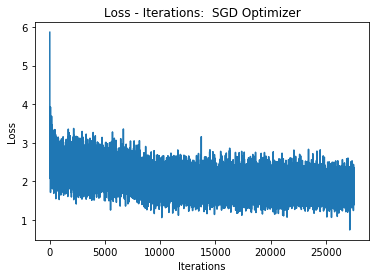

In [17]:
with open('trained_weights/vgg16_ssd_stats_SGD_feature_fusion.pkl','rb') as f:
    l_loss, c_loss, itr = pickle.load(f)

%matplotlib inline

l_loss = np.asarray(l_loss)
c_loss = np.asarray(c_loss)
itr = np.asarray(itr)
plt.plot(itr,l_loss+c_loss)
plt.title('Loss - Iterations:  SGD Optimizer')
plt.xlabel('Iterations')
plt.ylabel('Loss')